# Lab 2: Personalizar Stable Diffusion

## Parte 2: Utilizar nuestra propia base de datos y entrenar un modelo con Textual Inversion

Hasta ahora vimos como utilizar los modelos que la comunidad ha entrenado, pero también es posible entrenar uno propio con nuestra base de datos propia. Hay varios métodos, cada uno requiere diferente capacidad computacional, así como también resulta en distinta calidad. En esta parte vamos a ver el método que se utiliza para aprender conceptos nuevos llamado **Textual Inversion**

### 2.1. Textual Inversion

Habiamos visto que para poder generar imágenes a partir de texto, se utiliza un **modelo** para codificar el texto y poder condicionar el modelo de difusión. A veces, cuando queremos entrenar un nuevo concepto en Stable Diffusion, es posible que el modelo sepa como crear ese concepto pero no sepa la palabra que lo forma. Textual Inversion es una técnica que trata de hallar solamente la palabra que conforma el concepto, por lo que no es computacionalmente tan pesado de entrenar.

![](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

_Solo es necesario utilizar 3 a 5 imágenes para enseñar nuevos conceptos a un modelo como Stable Diffusion para obtener la generación de imágenes personalizada [1]._

Esta técnica fue introducida en [An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion.](https://arxiv.org/abs/2208.01618) Este paper demostró el concepto utilizando un modelo de difusión latente pero la idea ha sido aplicada a otras variantes como Stable Diffusion.

**Como funciona**

![](https://textual-inversion.github.io/static/images/training/training.JPG)

Antes de que cualquier prompt de texto pueda ser usado en el modelo de difusión, primero debe ser procesado en su representación númerica. Esto tipicamente implica tokenizar el texto, convertir cada token en un embedding y luego alimentar esos embeddings a tráves de un modelo (tipicamente un _transformer_) cuya salida será utilizada para el condicionamiento del modelo de difusión.

### 2.2. Instalar las librerías requeridas

In [1]:
!pip install -q -U transformers diffusers==0.14.0 accelerate ftfy fpuna-stable-diffusion
import os
import torch

### 2.3. Configuraciones para enseñar el nuevo concepto

In [16]:
#@markdown `pretrained_model_name_or_path` que versión de Stable Diffusion quieres usar de base
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

### Obtener las imágenes de entrenamiento

#### Descargar las imágenes de internet y almacenarlas localmente

También puedes subir las imágenes a colab o cargar desde google drive, mira la siguiente sección si quieres usar ese método.

In [5]:
urls = [
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/01.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/02.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/03.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/04.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/05.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/06.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/07.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/08.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/09.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/10.jpg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/11.jpeg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/12.jpeg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/13.jpeg",
    "https://huggingface.co/datasets/mfidabel/nicoespb-art/resolve/main/nicoespb-art/14.jpeg"
]

In [9]:
from fpuna_stable_diffusion.utils import download_image

images = list(filter(None,[download_image(url).resize((512, 512)) for url in urls]))
save_path = "./mi_concepto"

if not os.path.exists(save_path):
    os.mkdir(save_path)
    
_ = [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]

#### [Opcional] Cargar las imágenes desde una carpeta local o desde google drive

También puedes usar tus propias imágenes de entrenamiento o subirlas a colab usando la pestaña de archivos y luego dando el path al directorio que contiene las imágenes.

*Asegurate de que la carpeta solo contiene imágenes, ya que la siguiente celda va a leer todos los archivos*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
images_path = "" #@param {type:"string"}

while not os.path.exists(str(images_path)):
    print('El images_path especificado no existe, use el explorador de colab para copiar el path:')
    images_path=input("")
    
save_path = images_path

####  Mira las imágenes que recien agregaste

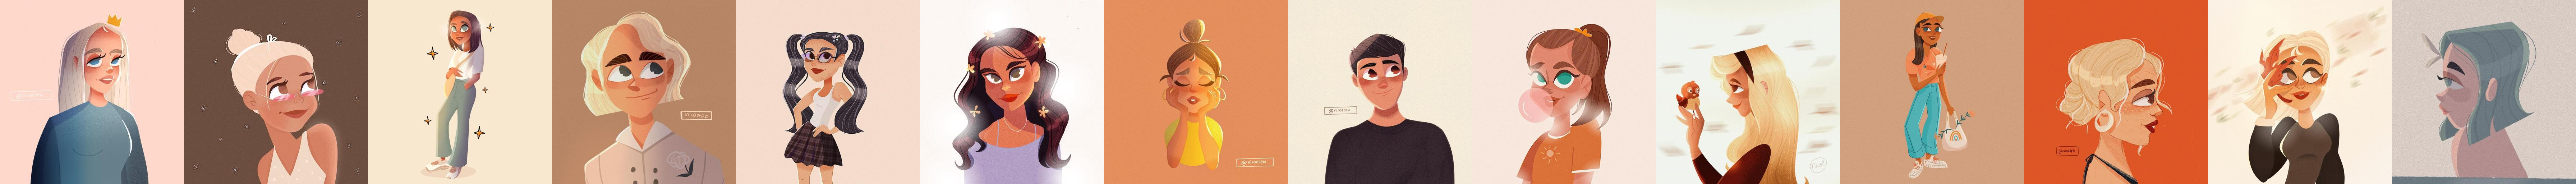

In [13]:
from PIL import Image
from fpuna_stable_diffusion.utils import image_grid

images = []
for file_path in os.listdir(save_path):
    try:
        image_path = os.path.join(save_path, file_path)
        images.append(Image.open(image_path).resize((512, 512)))
    except:
        print(f"{image_path} no es una imagen válida, por favor remueve esta imagen o el entrenamiento puede fallar.")
        
image_grid(images, 1, len(images))

## Configuraciones para el concepto nuevo

In [15]:
#@markdown `what_to_teach`: ¿qué es lo que estas enseñando? `object` te permite enseñar un objeto nuevo a ser enseñado, `style` te permite enseñar un nuevo estilo que puede ser usado.
what_to_teach = "style" #@param ["object", "style"]
#@markdown `placeholder_token` es el token que vas a usar para representar el nuevo concepto (de tal manera que cuando escribas el texto, vas a escribir "A `<my-placeholder-token>` in an amusement park"). Usamos los símbolos para evitar confusiones con las otras palabras.
placeholder_token = "<nicoespb-art>" #@param {type:"string"}
#@markdown `initializer_token` es la palabra que resume que es tu concepto, puede ser usado como un punto de partida
initializer_token = "artwork" #@param {type:"string"}

## Enseña al modelo el nuevo concepto (fine-tuning con textual inversion)

Ejecuta esta secuencia de celdas para correr el proceso de entrenamiento. El proceso completo puedo tomar de 1-4 horas.
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

### Configurando el modelo

#### Cargar el tokenizador y luego agregar nuestro nuevo token

In [11]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Agregar el token nuevo
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"El Tokenizer ya contiene {placeholder_token}. Por favor pasa otro "
        " `placeholder_token` que aún no este en el tokenizer."
    )

1

#### Obtener los Tokens IDs para nuestra palabra nueva y el token de inicialización. 

In [ ]:
# TODO: Agregar imagen donde se muestran que hace las líneas de Código

In [19]:
# Convertir el token de inicialización y de placeholder en ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)

# Verificar si initializer_token es un solo token o una secuencia de token
if len(token_ids) > 1:
    raise ValueError("El token de inicialización debe ser un solo token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

## Cargar el modelo de Stable Diffusion

In [ ]:
# TODO: Imagenes de los componentes

In [20]:
from transformers import CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

Como agregamos nuestro `placeholder_token` en el `tokenizer`, debemos cambiar el tamaño de los token embeddings, esto va a crear un nuevo vector en los token embeddings para nuestro `placeholder_token`.

In [21]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

Inicializamos el vector del placeholder token con los embeddings del token de inicialización.

In [22]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

En Textual-Inversion solo entrenamos el vector de embedding que agregamos, así que vamos a congelar el resto del modelo aquí.

In [23]:
import itertools

def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Congelar vae y unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())

# Congelar todos los parámetros excepto los embeddings de los tokens del codificador de texto
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)

freeze_params(params_to_freeze)

### Creando nuestros datos de entrenamiento

Vamos a crear el dataset y el DataLoader

In [24]:
from fpuna_stable_diffusion.lab2 import TextualInversionDataset

train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach,
      center_crop=False,
      set="train",
)

In [25]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Creamos el Scheduler de Ruido para el entrenamiento

In [26]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")

### Entrenamiento

Definimos los hiperparametros para nuestro entrenamiento.

Si no estas felíz con los resultados, puedes tunear el `learning_rate` y el `max_train_steps`

In [2]:
#@title Configurando los argumentos de entrenamiento
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

Entrenar !

### 2.4. Enseñar al modelo el nuevo concepto (fine-tuning)

In [21]:
from fpuna_stable_diffusion.lab2 import training_function
import accelerate

accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=1)

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad  # Liberar memoria
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Corre el código con tu nuevo modelo entrenado

Si acabas de entrenar tu modelo con el código de arriba, ejecuta este bloque para utilizarlo.

Si quieres guardar el concepto para reusarlo más tarde, descarga el archivo `learned_embeds.bin` o guardalo en la librería de conceptos.

Usa el [Cuaderno Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) para inferencia con conceptos pre-entrenados guardados.

In [3]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

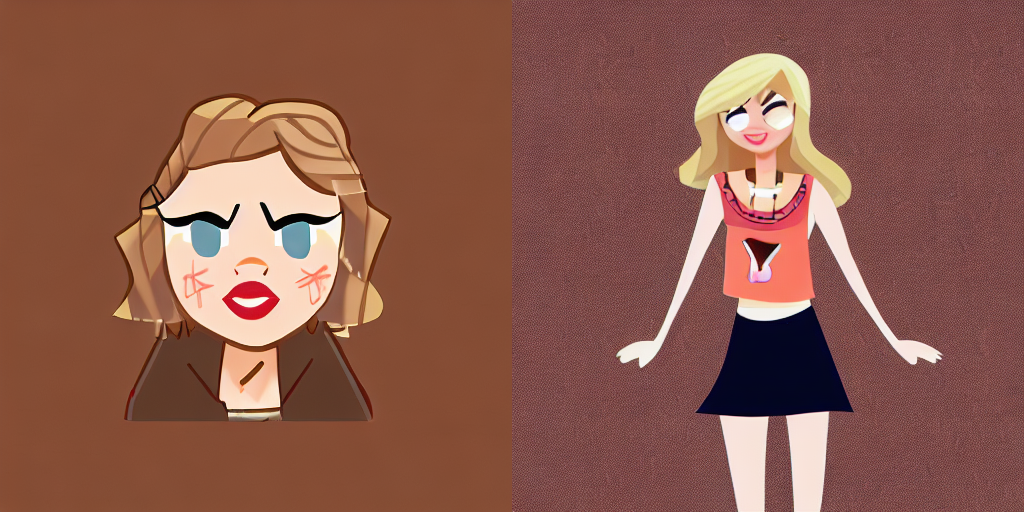

In [22]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt
from fpuna_stable_diffusion.utils import image_grid
prompt = "taylor swift in <nicoespb-art> style" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

generator = torch.Generator("cuda").manual_seed(42)

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5, generator=generator).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

## \[Opcional\] Guardar tu nuevo concepto en la [librería de conceptos](https://huggingface.co/sd-concepts-library).

In [ ]:
save_concept_to_public_library = True #@param {type:"boolean"}
name_of_your_concept = "Cat toy" #@param {type:"string"}
#@markdown `hf_token_write`: [Tienes que crear uno con permisos para escribir](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
    from slugify import slugify
    from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
    from huggingface_hub import create_repo
    repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
    output_dir = hyperparameters["output_dir"]
    if(not hf_token_write):
        with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
    else:
        hf_token = hf_token_write
    #Join the Concepts Library organization if you aren't part of it already
    !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
    images_upload = os.listdir("mi_concepto")
    image_string = ""
    repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
    for i, image in enumerate(images_upload):
        image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
    if(what_to_teach == "style"):
        what_to_teach_article = f"a `{what_to_teach}`"
    else:
        what_to_teach_article = f"an `{what_to_teach}`"
    readme_text = f'''---
license: mit
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
    #Save the readme to a file
    readme_file = open("README.md", "w")
    readme_file.write(readme_text)
    readme_file.close()
    #Save the token identifier to a file
    text_file = open("token_identifier.txt", "w")
    text_file.write(placeholder_token)
    text_file.close()
    #Save the type of teached thing to a file
    type_file = open("type_of_concept.txt","w")
    type_file.write(what_to_teach)
    type_file.close()
    operations = [
        CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
        CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
        CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
        CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
    ]
    create_repo(repo_id,private=True, token=hf_token)
    api = HfApi()
    api.create_commit(
        repo_id=repo_id,
        operations=operations,
        commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
        token=hf_token
      )
    api.upload_folder(
        folder_path=save_path,
        path_in_repo="concept_images",
        repo_id=repo_id,
        token=hf_token
  )